# Study 1: Gender stereotype consistent vs Gender stereotype inconsisten information

In this study, the authors utilize the framework from [Kashima 2000 "Maintaining Cultural Stereotypes in the Serial Reproduction of Narratives"](https://journals.sagepub.com/doi/abs/10.1177/0146167200267007?journalCode=pspc) for a transmission chain experiment involving LLMs.

The story used in the experiment, as described in the cited paper, is available in `study-data/stories/kashima.txt`. This narrative contains several instances of information consistent with and inconsistent with gender stereotypes. Kashima 2000 hand-coded phrases that exemplify each category and further Acerbi et al. hand-coded the summaries in the experiment according to these phrases.

### Overview of Notebook sections

1. **Section 1 Authors' results**: We replicate the authors' analysis to understand how information is retained or altered through the transmission chains, answering questions like what models should be used, and what metrics should be used to ascertain our hypothesis? We will focus on Linear Mixed-Effect Regression analysis, a common approach in behavioral studies to determine the impact of specific variables or interventions.

3. **Authors' Summaries / GPT-4 Evaluation**: Here, we transition from manual to automated evaluation by utilizing GPT-4 to evaluate the summaries, allowing for more efficient and scalable analysis. 
   
4. **Section 3 New Summaries / GPT-4 Evaluation**: This final section involves a full replication of the experiment. We will start by generating new summaries using GPT-3.5, followed by an evaluation with GPT-4 to compare the bias retention across different steps.


#### Additional Notes:

1. **Model Flexibility**: While this tutorial primarily uses GPT models, `openai_model.py` can be adapted to include classes for querying different models.

2. **Code Structure**: Most of the functional code resides within classes. These notebooks will primarily focus on initializing and utilizing these classes rather than building them from scratch. The goal is to provide a walkthrough of the experiments while blending social science methodologies with computational techniques.

3. **Other notebooks**: Rest of the notebooks will follow the same structure. There will be less explanation as that can be understood from reading the pre-reg document. There will be some differences relevant to the specific tasks. 

### Primer on Linear Mixed Effects Regression (LMER)

For a formal introduction to LMER, refer to ["Linear models and linear mized effects models in R"](https://arxiv.org/ftp/arxiv/papers/1308/1308.5499.pdf)

**Linear models vs LMER**: Linear models assume independence among all observations. However, this assumption may not hold true when multiple measurements are taken from the same subject, leading to non-independence among observations and potentially violating the independence assumption. LMERs address this by incorporating sources of variation into the model, thus rendering the dataset effectively independent. LMER is essentially a linear model that includes additional effects.

**Mixed Effects: Fixed Effects + Random Effects**

1. **Fixed Effects**: These represent the systematic components of the study. They are the variables considered important predictors of the outcome.

2. **Random Effects**: These represent the unsystematic components. They are variables that affect the results from measurement to measurement.

For instance, in studies measuring the pitch of subjects, multiple measurements might be taken from the same subject. Each subject will have their own baseline pitch. Therefore, to assess the impact of sex on pitch, an LMER that includes subject ID as one of the predictors is necessary. In the formula, this is often denoted as "(1 | subject ID)", treating each subject as a separate predictor.

**Common Assumptions in LMER**

LMER is commonly used in social sciences to determine the impact of certain effects on the outcome. These models have the following assumptions --

1. **Linearity**: The outcome must be a linear combination of the predictors.
   
2. **Absence of Collinearity**: The fixed effects (predictors) should not be correlated with each other.
   
3. **Independence**: Each data point should be independent of others, an assumption addressed by LMER as discussed above.
   
4. **Homoscedasticity**: The variability of data should be approximately equal across the predicted values range. This is typically verified by examining residuals to ensure they deviate 
   
5. **Normality of residuals**: How large is significant? The residuals are ideally expected to be normally distributed. However, this assumption is the least critical of all and can be violated.

## Setup

In [18]:
import asyncio
import collections
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from docx import Document
from rpy2.robjects import r, pandas2ri

import sys
sys.path.append("../")
from utils import setup_transmission_chain
from tasks import TaskFactory
from enums import TaskType, AzureOpenAIModelType
from node import Node
from openai_model import AzureOpenAIModel

study_data = Path("../study-data/").resolve()


index_consistent = ['BMC', 'PMC', 'PFC', 'BFC']
index_inconsistent = ['BMI', 'PMI', 'PFI', 'BFI']

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
def lmer(data):
    """Performs LMER."""
    pandas2ri.activate() 

    # Load the lme4 library in R
    r('library(lme4)')
    r('library(lmerTest)')
    
    # Convert the DataFrame to an R data.frame
    rdf = pandas2ri.py2rpy(data)
    
    # Fit the model in R
    r.assign('rdf', rdf)
    r('rdf$content <- factor(rdf$content, levels = c("inconsistent", "consistent"))')
    model = r('lmer(proportion ~ content + (1|chain_step) + (1|chain_id), data=rdf)')
    
    # Print the summary
    print(r('summary')(model))


def plot(data, ax):
    max_gen = int(data["chain_step"].max())
    for label, color in [('consistent', 'orange'), ('inconsistent', 'gray')]:
        means, stds = [], []
        for gen in range(max_gen+1):
            filter = (data["chain_step"] == gen) & (data["content"] == label)
            means.append(data.loc[filter, "proportion"].mean())
            stds.append(data.loc[filter, "proportion"].std() / np.sqrt(sum(filter))) 
        ax.plot(range(max_gen + 1), means, color=color, alpha=0.5, label=label)
        ax.errorbar(range(max_gen + 1), means, yerr=stds, color=color, alpha=0.5, capsize=5)
        ax.scatter(range(max_gen + 1), means, color=color)

    return ax


## Section 1: Author's results

### LMER for Transmission Chains


The hypothesis that Acerbi et al. 2023 are testing is as follows: the content type determines the proportion of information retained through the transmission chains.

These are the variables that we need to consider:

- **proportion**: This is the quantitative estimate of biases retained in transmission.

- **content**: This is a categorical variable taking two values, either "Gender-stereotype consistent" or "Gender-stereotype inconsistent".

- **chain_step**: This represents the numerical step in a chain and is used as a random effect.

- **chain_id**: This represents the numerical id of a chain, i.e., experiment. It is used as a random effect.

The formula used is (this is also how R specifies the model): 

proportion ~ content + (1|chain_step) + (1|chain_id)

The function `lmer` is written to performs the above analysis in R as there is no suitable library in Python to do so. 


Let's start by reading the data that author's have analyzed 

In [20]:
exp_data = pd.read_excel(str(study_data / "coding/study1.xlsx"))
exp_data.head()

,Unnamed: 0,chain 1,chain 2,chain 3,chain 4,chain 5,Unnamed: 6,chain 1.1,chain 2.1,chain 3.1,chain 4.1,chain 5.1,Unnamed: 12,chain 1.2,chain 2.2,chain 3.2,chain 4.2,chain 5.2
0,BMC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,James is an up-and-coming executive in a top c...,x,x,x,x,NaN,NaN,NaN,x,x,x,NaN,NaN,NaN,NaN,x,x,NaN
2,while James takes the opportunity to choose th...,NaN,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,x
3,"and confident it was going to run smoothly,",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,James settles down for an afternoon of Wide Wo...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Column 1 contains text. These are the phrases from the original story. They have been manually coded into several categories. The details of these categories can be read from "pre-reg" documentation in `study-data/pre-reg/chatGPT transmission chains.pdf`. For example, BMC means Background Male-stereotype Consistent phrases. There are eight of these categories with all of the combinations of the following labels - 

1. B/P: Background / Plot-relevant
2. M/F: Male-stereotype / Female-stereotype
3. C/I: Consistent / Inconsistent 

Each experiment is a chain. There are five chains of 3 steps each. Hence the columns corresponding to the step 1 of each experiment are chain 1, chain 2, ..., chain 5. Similarly, the columns corresponding to the step 2 of each experiment are chain 1.1, chain 2.1, ..., chain 5.1. 

Let's clean the data a bit by giving it the suitable column names. 

In [21]:
exp_data = pd.read_excel(str(study_data / "coding/study1.xlsx"))


## What did the experimental say about these codes for the summary?
exp_analysis = []
for row in exp_data.iterrows():
    x = row[1]['Unnamed: 0']

    if pd.isna(x):
        continue 

    if x in index_consistent or x in index_inconsistent:
        cat = x
        continue
    else:
        phrase = x

    x = [
        phrase, cat,
        *[1 if row[1][f'chain {y}{z}'] == 'x' else 0 for y in range(1, 6) for z in ['', '.1', '.2'] ]
    ]

    exp_analysis.append(x)

columns = ['Text part', 'Type', 'sim:0 gen:0', 'sim:0 gen:1', 'sim:0 gen:2',
       'sim:1 gen:0', 'sim:1 gen:1', 'sim:1 gen:2', 'sim:2 gen:0',
       'sim:2 gen:1', 'sim:2 gen:2', 'sim:3 gen:0', 'sim:3 gen:1',
       'sim:3 gen:2', 'sim:4 gen:0', 'sim:4 gen:1', 'sim:4 gen:2'] # analysis.columns
exp_analysis = pd.DataFrame(exp_analysis, columns=columns)

We will aggregate the data in chains so that we have counts for each content type. 

In [22]:

sim_cols = exp_analysis.columns[2:]
results_exp = {}
for col in sim_cols:
    codes = exp_analysis[exp_analysis[col] == 1]['Type']
    results_exp[col] = collections.Counter(codes)
results_exp['original'] = collections.Counter(exp_analysis['Type'])
results_exp = pd.DataFrame(results_exp)
results_exp = results_exp.fillna(0)

# baselines 
PLOT_STEREOTYPE_CONSISTENT = ['PFC', 'PMC']
PLOT_STEREOTYPE_INCONSISTENT = ['PFI', 'PMI']

baseline_PC = results_exp.loc[PLOT_STEREOTYPE_CONSISTENT, 'original'].sum() / results_exp.loc[index_consistent, 'original'].sum() 
baseline_PI = results_exp.loc[PLOT_STEREOTYPE_INCONSISTENT, 'original'].sum() / results_exp.loc[index_inconsistent, 'original'].sum() 


orig_cons_sum = results_exp.loc[index_consistent, "original"].sum()
orig_incons_sum = results_exp.loc[index_inconsistent, "original"].sum()

Now, we prepare the data that needs to be sent to `lmer` for analysis in R and `plot` for plotting. 

R[write to console]: boundary (singular) fit: see help('isSingular')



Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: proportion ~ content + (1 | chain_step) + (1 | chain_id)
   Data: rdf

REML criterion at convergence: -74.1

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.1104 -0.6147 -0.3847  0.8702  1.8839 

Random effects:
 Groups     Name        Variance Std.Dev.
 chain_id   (Intercept) 0.001132 0.03365 
 chain_step (Intercept) 0.000000 0.00000 
 Residual               0.002874 0.05361 
Number of obs: 30, groups:  chain_id, 5; chain_step, 3

Fixed effects:
                  Estimate Std. Error       df t value Pr(>|t|)    
(Intercept)        0.16250    0.02045  6.63429   7.948 0.000126 ***
contentconsistent  0.05855    0.01958 24.00000   2.991 0.006338 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
cntntcnsstn -0.479
optimizer (nloptwrap) convergence code: 0 (OK)
boundary (singular) fit: see help('isSingular')




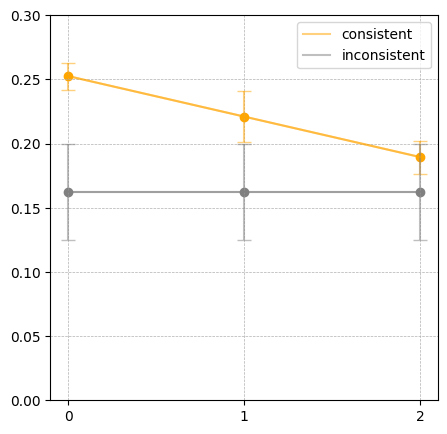

In [23]:
# prepare data
data_exp = []
for col in results_exp.columns:
    if col == "original":
        continue
    
    cons_prop = results_exp.loc[index_consistent, col].sum() / orig_cons_sum
    incons_prop = results_exp.loc[index_inconsistent, col].sum() / orig_incons_sum

    x = (int(col[4]), int(col[-1]), cons_prop, 'consistent')
    data_exp.append(x)

    x = (int(col[4]), int(col[-1]), incons_prop, 'inconsistent')
    data_exp.append(x)

data_exp = pd.DataFrame(data_exp, columns=["chain_id", "chain_step", "proportion", "content"])

#lmer
lmer(data_exp)

# plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5), dpi=100)
plot(data_exp, ax)
ax.set_xticks([0, 1, 2])
ax.set_ylim(0, 0.3)
ax.grid(which='both', linestyle='--', linewidth=0.5)
ax.legend()

## Section 2: Authors' summaries / GPT Evaluation

In this section, we will query the LLM to evaluate the author summaries. 

Let's load the summaries.

In [24]:
summaries = []
doc = Document(str(study_data / "output/Stereotype consistency.docx"))
for para in doc.paragraphs:
    if para.text:
        summaries.append(para.text)

### Steps to evaluate

**Node**: A transmission chain is composed of nodes. Each node performs two functions: (a) it queries the LLM once all inputs are gathered, and (b) it evaluates the LLM’s response. In the code below, we append the input to each node so that, when the process starts, they can proceed directly to evaluation.

**LLM Models**: These are defined in `openai_model.py`. For this example, we will use AzureOpenAIModel.

**TaskFactory**: This class instantiates `Task` objects. Each task is composed of data relevant to the task and the evaluation process, including task-relevant prompts.

**TaskType**: This is used to define the category of the task under study. Refer to `enums.TaskType` for additional options.

**Code Design**: Examine the code in `tasks.py` to understand the code design.

**Transmission Chain Setup**: We define the transmission chain using `utils.setup_transmission_chain`. Refer to the function's docstring to understand how the input is structured. The transmission chain is divided into generations, and each generation is further divided into nodes. This structure is represented as a list of lists.

**Node Output**: When a node is printed, it displays the following:

Sim:\<simulation number\/experiment number\> ID:(\<Generation number\>, \<node number\>) \tIncoming nodes: []\tOutgoing nodes: []"

In [25]:
# define the chain
connections = [
    [[0]],
    [[0]],
]

# run all at once
n_simulations = 5

# define the api and task
llm_model_execute = None
llm_model_evaluate = AzureOpenAIModel(AzureOpenAIModelType.GPT_4, {'temperature': 0.1, 'max_tokens': 500})
task = TaskFactory.create(TaskType.GENDER_STEREOTYPE_CONSISTENCY, llm_model_execute, llm_model_evaluate)

simulations = []
for idx in range(n_simulations):
    all_nodes = setup_transmission_chain(connections, Node, task, idx)

    all_nodes[0][0].output = summaries[idx]
    all_nodes[1][0].inputs.append(summaries[idx])
    
    all_nodes[1][0].output = summaries[idx + 5]
    all_nodes[2][0].inputs.append(summaries[idx + 5])
    
    all_nodes[2][0].output = summaries[idx + 2*5]
    simulations.append(all_nodes)
    

In [26]:
async def run_evaluation(all_nodes):
    await asyncio.gather(*[node.start() for generation in all_nodes for node in generation])

await asyncio.gather(*[run_evaluation(all_nodes) for all_nodes in simulations])

Evaluated:  2 (1, 0)
Evaluated:  4 (2, 0)
Evaluated:  3 (1, 0)
Evaluated:  0 (0, 0)
Evaluated:  2 (0, 0)
Evaluated:  2 (2, 0)
Evaluated:  4 (1, 0)
Evaluated:  4 (0, 0)
Evaluated:  1 (1, 0)
Evaluated:  3 (0, 0)
Evaluated:  3 (2, 0)
Evaluated:  1 (0, 0)
Evaluated:  0 (2, 0)
Evaluated:  1 (2, 0)
Evaluated:  0 (1, 0)


[None, None, None, None, None]

Here is what the input means.

    Evaluated: {simulation id} ({generation number}, {node number})

Every time evaulation is complete, above is printed. This is just a progress marker. 

Let's take the evaluations and put them in the same format as original evaluations.

In [27]:
# prepare data
analysis = exp_analysis[['Text part', 'Type']]
for sim_id, all_nodes in enumerate(simulations):
    for generation in all_nodes:
        for node in generation:
            col = f"sim:{sim_id} gen:{node.id[0]}"
            analysis.loc[:, col] = 0
            stripped_text = exp_analysis['Text part'].apply(lambda x:x.strip())
            for x in node.evaluation.split("\n"):
                row = stripped_text == x
                if sum(row) == 0:
                    continue
                analysis.loc[row, col] = 1

/var/folders/zw/zxjz6rs15sb_83d0ljgh9s440000gq/T/ipykernel_19260/2474698503.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analysis.loc[:, col] = 0
/var/folders/zw/zxjz6rs15sb_83d0ljgh9s440000gq/T/ipykernel_19260/2474698503.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analysis.loc[:, col] = 0
/var/folders/zw/zxjz6rs15sb_83d0ljgh9s440000gq/T/ipykernel_19260/2474698503.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

Now, we can use the same pipeline as in section 1. 

R[write to console]: boundary (singular) fit: see help('isSingular')



Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: proportion ~ content + (1 | chain_step) + (1 | chain_id)
   Data: rdf

REML criterion at convergence: -63.2

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-1.90553 -0.70911  0.02095  0.39439  2.38302 

Random effects:
 Groups     Name        Variance  Std.Dev.
 chain_id   (Intercept) 0.0009409 0.03067 
 chain_step (Intercept) 0.0000000 0.00000 
 Residual               0.0044932 0.06703 
Number of obs: 30, groups:  chain_id, 5; chain_step, 3

Fixed effects:
                  Estimate Std. Error       df t value Pr(>|t|)    
(Intercept)        0.27917    0.02208  8.06714  12.641 1.34e-06 ***
contentconsistent -0.01601    0.02448 23.99996  -0.654    0.519    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
cntntcnsstn -0.554
optimizer (nloptwrap) convergence code: 0 (OK)
boundary (singular) fit: see help('isS

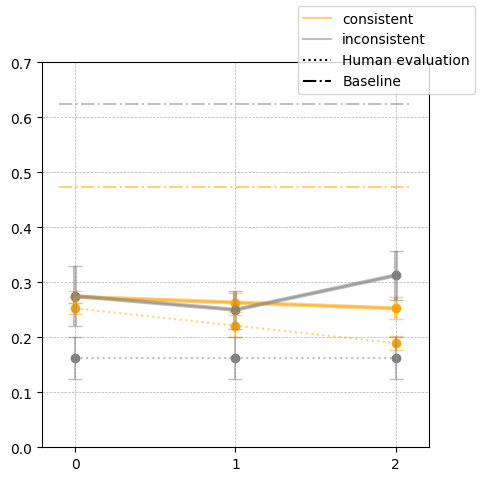

In [28]:
sim_cols = analysis.columns[2:]
results = {}
for col in sim_cols:
    codes = analysis[analysis[col] == 1]['Type']
    results[col] = collections.Counter(codes)
results['original'] = collections.Counter(analysis['Type'])
results = pd.DataFrame(results)
results = results.fillna(0)

data = []
for col in results.columns:
    if col == "original":
        continue
    
    cons_prop = results.loc[index_consistent, col].sum() / orig_cons_sum
    incons_prop = results.loc[index_inconsistent, col].sum() / orig_incons_sum

    x = (int(col[4]), int(col[-1]), cons_prop, 'consistent')
    data.append(x)

    x = (int(col[4]), int(col[-1]), incons_prop, 'inconsistent')
    data.append(x)

data = pd.DataFrame(data, columns=["chain_id", "chain_step", "proportion", "content"])


lmer(data)

# plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5), dpi=100)

max_gen = int(data["chain_step"].max())
for label, color in [('consistent', 'orange'), ('inconsistent', 'gray')]:
    means, stds = [], []
    for gen in range(max_gen+1):
        filter = (data["chain_step"] == gen) & (data["content"] == label)
        means.append(data.loc[filter, "proportion"].mean())
        stds.append(data.loc[filter, "proportion"].std() / np.sqrt(sum(filter)))
    ax.plot(range(max_gen + 1), means, color=color, alpha=0.5, label=label)
    ax.errorbar(range(max_gen + 1), means, yerr=stds, color=color, alpha=0.5, capsize=5, linewidth=3)
    ax.scatter(range(max_gen + 1), means, color=color)

# Overlay human evaluation
for label, color in [('consistent', 'orange'), ('inconsistent', 'gray')]:
    means, stds = [], []
    for gen in range(max_gen+1):
        filter = (data_exp["chain_step"] == gen) & (data_exp["content"] == label)
        means.append(data_exp.loc[filter, "proportion"].mean())
        stds.append(data_exp.loc[filter, "proportion"].std() / np.sqrt(sum(filter))) 
    ax.errorbar(range(max_gen + 1), means, yerr=stds, color=color, alpha=0.5, capsize=5, linestyle=":")
    ax.scatter(range(max_gen + 1), means, color=color)

# Overlay baseline PC/PI
xmin, xmax = ax.get_xlim()
ax.hlines(y=baseline_PC, xmin=xmin, xmax=xmax, linestyle="-.", color='orange', alpha=0.5)
ax.hlines(y=baseline_PI, xmin=xmin, xmax=xmax, linestyle="-.", color='gray', alpha=0.5)

ax.set_xticks([0, 1, 2])
ax.set_ylim(0, 0.7)
ax.grid(which='both', linestyle='--', linewidth=0.5)

# legends
# Add custom legend lines
human_legend = plt.Line2D([0], [0], color='black', linestyle=':', label='Human evaluation')
baseline_legend = plt.Line2D([0], [0], color='black', linestyle='-.', label='Baseline')

handles, labels = ax.get_legend_handles_labels()

handles.extend([human_legend, baseline_legend])
labels.extend(['Human evaluation', 'Baseline'])

# Create the legend with the combined handles and labels
fig.legend(handles, labels)

**Note:** Observing that the GPT-4 evaluation indicates no bias in LLMs might suggest a lack of bias. However, this only implies that a more extensive human experiment should be conducted to confirm the absence of such biases.

## Section 3: GPT summaries / GPT Evaluation

Now, we can build even bigger chains and see how the content type varies in each chain. 

**Note:** we don't append any inputs this time because we will query LLMs to summarize stories. 

In [29]:
# define the api and task
llm_model_execute = AzureOpenAIModel(AzureOpenAIModelType.GPT_3_5_TURBO, {})
llm_model_evaluate = AzureOpenAIModel(AzureOpenAIModelType.GPT_4, {'temperature': 0.1, 'max_tokens': 500})
task = TaskFactory.create(TaskType.GENDER_STEREOTYPE_CONSISTENCY, llm_model_execute, llm_model_evaluate)

# define simulations asynchornously
async def run_simulation(connecitons, task, sim_idx):
    all_nodes = setup_transmission_chain(connections, Node, task, sim_idx)
    await asyncio.gather(*[node.start() for generation in all_nodes for node in generation ])
    return all_nodes

# define the chain
connections = [
    [[0]],
    [[0]],
    [[0]],
    [[0]],
    [[0]],
    [[0]],
]

# run all at once
n_simulations = 5
completed = [run_simulation(connections, task, idx) for idx in range(n_simulations)]
simulations = await asyncio.gather(*completed)

for i, all_nodes in enumerate(simulations):
    print(f"Simulation {i + 1} completed.")

Processed [Sim:0 ID:(1, 0)	Incoming nodes: [(0, 0)]	Outgoing nodes: [(2, 0)]]
Processed [Sim:3 ID:(1, 0)	Incoming nodes: [(0, 0)]	Outgoing nodes: [(2, 0)]]
Processed [Sim:1 ID:(1, 0)	Incoming nodes: [(0, 0)]	Outgoing nodes: [(2, 0)]]
Processed [Sim:2 ID:(1, 0)	Incoming nodes: [(0, 0)]	Outgoing nodes: [(2, 0)]]
Processed [Sim:4 ID:(1, 0)	Incoming nodes: [(0, 0)]	Outgoing nodes: [(2, 0)]]
Processed [Sim:0 ID:(2, 0)	Incoming nodes: [(1, 0)]	Outgoing nodes: [(3, 0)]]
Processed [Sim:3 ID:(2, 0)	Incoming nodes: [(1, 0)]	Outgoing nodes: [(3, 0)]]
Processed [Sim:1 ID:(2, 0)	Incoming nodes: [(1, 0)]	Outgoing nodes: [(3, 0)]]
Processed [Sim:4 ID:(2, 0)	Incoming nodes: [(1, 0)]	Outgoing nodes: [(3, 0)]]
Processed [Sim:0 ID:(3, 0)	Incoming nodes: [(2, 0)]	Outgoing nodes: [(4, 0)]]
Processed [Sim:2 ID:(2, 0)	Incoming nodes: [(1, 0)]	Outgoing nodes: [(3, 0)]]
Processed [Sim:3 ID:(3, 0)	Incoming nodes: [(2, 0)]	Outgoing nodes: [(4, 0)]]
Processed [Sim:4 ID:(3, 0)	Incoming nodes: [(2, 0)]	Outgoing nod

In [30]:
# prepare data
analysis = exp_analysis[['Text part', 'Type']]
for sim_id, all_nodes in enumerate(simulations):
    for generation in all_nodes:
        for node in generation:
            col = f"sim:{sim_id} gen:{node.id[0]}"
            analysis.loc[:, col] = 0
            stripped_text = exp_analysis['Text part'].apply(lambda x:x.strip())
            for x in node.evaluation.split("\n"):
                row = stripped_text == x
                if sum(row) == 0:
                    continue
                analysis.loc[row, col] = 1

/var/folders/zw/zxjz6rs15sb_83d0ljgh9s440000gq/T/ipykernel_19260/2474698503.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analysis.loc[:, col] = 0
/var/folders/zw/zxjz6rs15sb_83d0ljgh9s440000gq/T/ipykernel_19260/2474698503.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analysis.loc[:, col] = 0
/var/folders/zw/zxjz6rs15sb_83d0ljgh9s440000gq/T/ipykernel_19260/2474698503.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: proportion ~ content + (1 | chain_step) + (1 | chain_id)
   Data: rdf

REML criterion at convergence: -46

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.6556 -0.7144  0.0128  0.4314  4.8846 

Random effects:
 Groups     Name        Variance  Std.Dev.
 chain_step (Intercept) 4.883e-03 0.069881
 chain_id   (Intercept) 2.511e-05 0.005011
 Residual               2.432e-02 0.155958
Number of obs: 70, groups:  chain_step, 7; chain_id, 5

Fixed effects:
                  Estimate Std. Error       df t value Pr(>|t|)    
(Intercept)        0.18929    0.03738  9.16744   5.063 0.000641 ***
contentconsistent -0.02086    0.03728 58.00506  -0.560 0.577868    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
cntntcnsstn -0.499



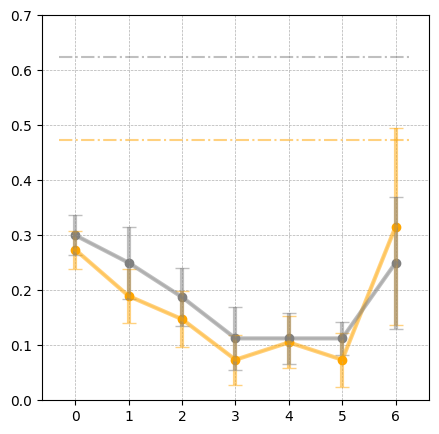

In [31]:
sim_cols = analysis.columns[2:]
results = {}
for col in sim_cols:
    codes = analysis[analysis[col] == 1]['Type']
    results[col] = collections.Counter(codes)
results['original'] = collections.Counter(analysis['Type'])
results = pd.DataFrame(results)
results = results.fillna(0)

data2 = []
for col in results.columns:
    if col == "original":
        continue
    
    cons_prop = results.loc[index_consistent, col].sum() / orig_cons_sum
    incons_prop = results.loc[index_inconsistent, col].sum() / orig_incons_sum

    x = (int(col[4]), int(col[-1]), cons_prop, 'consistent')
    data2.append(x)

    x = (int(col[4]), int(col[-1]), incons_prop, 'inconsistent')
    data2.append(x)

data2 = pd.DataFrame(data2, columns=["chain_id", "chain_step", "proportion", "content"])


lmer(data2)

# plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5), dpi=100)

max_gen = int(data2["chain_step"].max())
for label, color in [('consistent', 'orange'), ('inconsistent', 'gray')]:
    means, stds = [], []
    for gen in range(max_gen+1):
        filter = (data2["chain_step"] == gen) & (data2["content"] == label)
        means.append(data2.loc[filter, "proportion"].mean())
        stds.append(data2.loc[filter, "proportion"].std() / np.sqrt(sum(filter)))
    ax.plot(range(max_gen + 1), means, color=color, alpha=0.25, label=label)
    ax.errorbar(range(max_gen + 1), means, yerr=stds, color=color, alpha=0.5, capsize=5, linewidth=3)
    ax.scatter(range(max_gen + 1), means, color=color)

# # Overlay human evaluation
# for label, color in [('consistent', 'orange'), ('inconsistent', 'gray')]:
#     means, stds = [], []
#     for gen in range(max_gen+1):
#         filter = (data_exp["chain_step"] == gen) & (data_exp["content"] == label)
#         means.append(data_exp.loc[filter, "proportion"].mean())
#         stds.append(data_exp.loc[filter, "proportion"].std() / np.sqrt(sum(filter))) 
#     ax.errorbar(range(max_gen + 1), means, yerr=stds, color=color, alpha=0.5, capsize=5, linestyle=":")
#     ax.scatter(range(max_gen + 1), means, color=color)

# # Overlay gpt evaluation
# for label, color in [('consistent', 'orange'), ('inconsistent', 'gray')]:
#     means, stds = [], []
#     for gen in range(max_gen+1):
#         filter = (data["chain_step"] == gen) & (data["content"] == label)
#         means.append(data.loc[filter, "proportion"].mean())
#         stds.append(data.loc[filter, "proportion"].std() / np.sqrt(sum(filter))) 
#     ax.errorbar(range(max_gen + 1), means, yerr=stds, color=color, alpha=0.5, capsize=5, linestyle="--", linewidth=2)
#     ax.scatter(range(max_gen + 1), means, color=color)

# Overlay baseline PC/PI
xmin, xmax = ax.get_xlim()
ax.hlines(y=baseline_PC, xmin=xmin, xmax=xmax, linestyle="-.", color='orange', alpha=0.5)
ax.hlines(y=baseline_PI, xmin=xmin, xmax=xmax, linestyle="-.", color='gray', alpha=0.5)

ax.set_xticks([0, 1, 2, 3, 4, 5, 6])
ax.set_ylim(0, 0.7)
ax.grid(which='both', linestyle='--', linewidth=0.5)

# legends
# Add custom legend lines
human_legend = plt.Line2D([0], [0], color='black', linestyle=':', label='HumanEval')
baseline_legend = plt.Line2D([0], [0], color='black', linestyle='-.', label='Baseline')
human_gpt_legend = plt.Line2D([0], [0], color='black', linestyle='--', linewidth=2, label='GPTEval Only')

handles, labels = ax.get_legend_handles_labels()

handles.extend([human_legend, baseline_legend, human_gpt_legend])
labels.extend(['HumanEval', 'Baseline', "GPTEval(Only)"])

# Create the legend with the combined handles and labels
# fig.legend(handles, labels)